# Introduction

This project demonstrates how to implement and analyze Random Forest algorithms for both classification and regression tasks using a real-world dataset: **medical insurance records**.

This algoritm was not covered in class, and my attempt at the algorithm is preliminary and not very accurate, but I used buit in methods to be able to better understand how they actually perform

We aim to:

- **Classify** whether an individual is a smoker based on demographic and health features.
- **Regress** a person’s medical expenses (`charges`) based on those same features.

---

## Key Definitions

### Decision Tree
A flowchart-like model that splits data based on feature thresholds to make predictions.

### Random Forest
An ensemble of $ M $ decision trees $ T_1, \dots, T_M $ whose predictions are combined by:

- **Majority vote** for classification:
  $$
  \hat{y}_{\text{clf}} = \arg\max_k \sum_{m=1}^M \mathbf{1}(T_m(x) = k)
  $$

- **Averaging** for regression:
  $$
  \hat{f}_{\text{reg}}(x) = \frac{1}{M} \sum_{m=1}^M T_m(x)
  $$

### Gini Impurity
A measure of node heterogeneity used during tree construction:
$$
G = \sum_{k=1}^K p_k (1 - p_k)
$$
where $ p_k $ is the proportion of class $ k $ in a node.

### Feature Importance
The total reduction in impurity (or error) attributable to each feature, averaged across all trees.

### Partial Dependence Plot (PDP)
Shows the marginal effect of one or two features on the predicted outcome, holding other features constant.

### Confusion Matrix
A $ 2 \times 2 $ table for binary classification showing true vs. predicted labels.

### ROC AUC
Area under the Receiver Operating Characteristic curve, summarizing the trade-off between true positive rate and false positive rate.

### MSE / MAE / $ R^2 $
Standard regression metrics:

- Mean Squared Error:
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
  $$
- Mean Absolute Error:
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
  $$
- Coefficient of Determination:
  $$
  R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
  $$

---

## We Will Implement

- A **Random Forest Classifier** to predict smoking status.
- A **Random Forest Regressor** to predict medical charges.
- **Model evaluation** through confusion matrices, ROC/AUC, precision-recall curves, scatter plots, residual analyses, and PDPs.
- A study of `max_depth` to understand **overfitting vs. underfitting**.

---

## Dataset

We use `insurance.csv` with **1,338 entries** and the following features:

- `age`, `sex`, `bmi`, `children`, `smoker`, `region`, `charges`

---

## Methodology

We will:

1. Explore and visualize data  
2. Encode categorical variables  
3. Split into train/test sets  
4. Train and evaluate both models  
5. Analyze feature importances and partial dependencies  
6. Examine the effect of tree depth on performance  

---

## Step 1: Exploratory Data Analysis

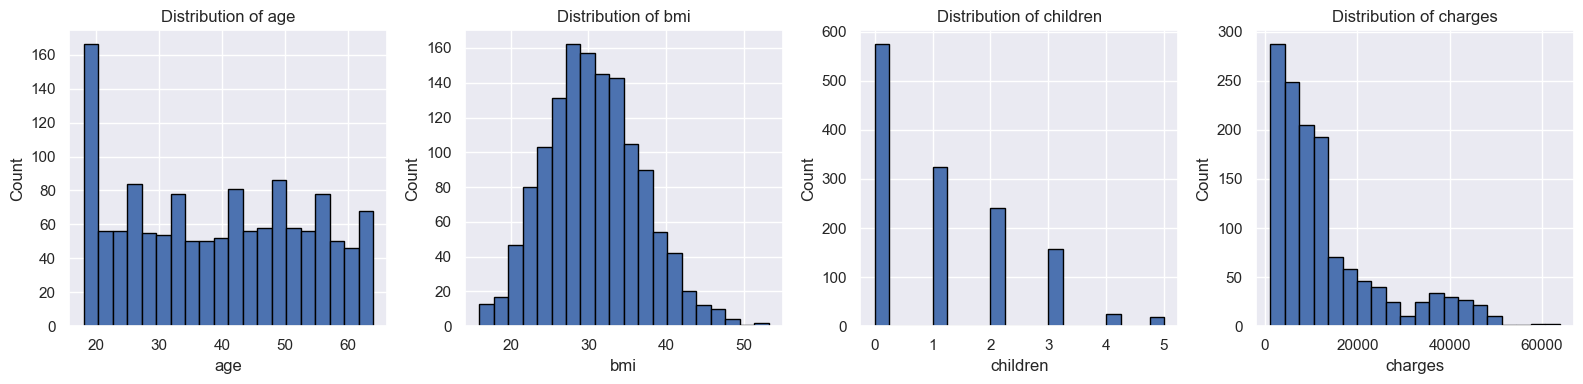

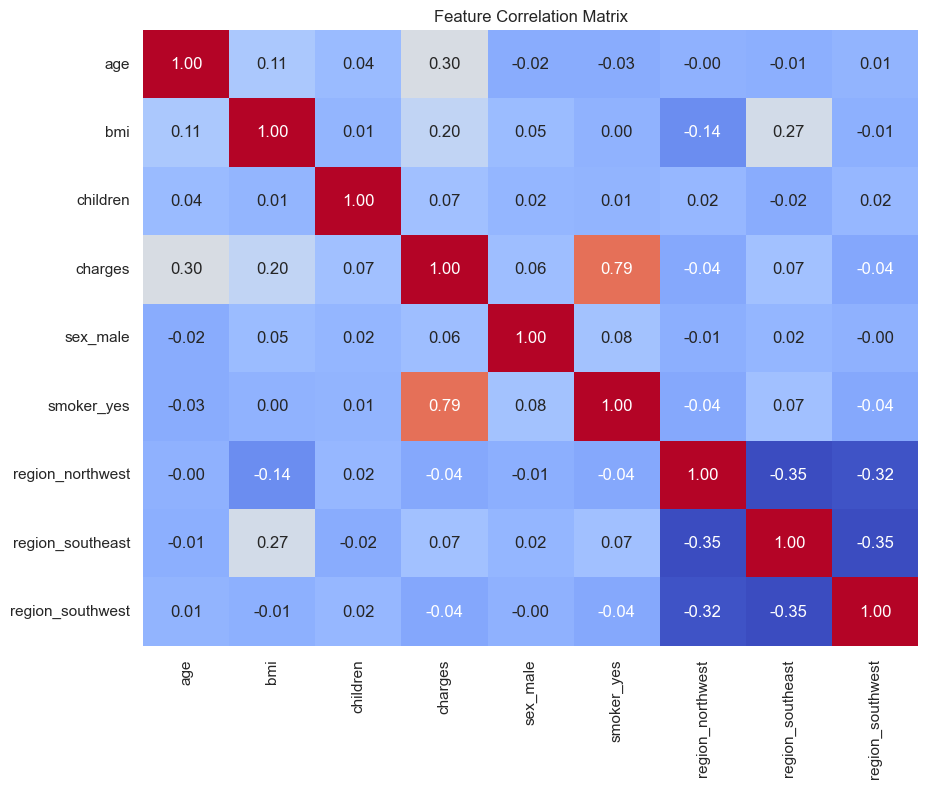

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
df = pd.read_csv("insurance.csv")

# Histograms of numerical features
plt.figure(figsize=(16,4))
for i, col in enumerate(['age','bmi','children','charges']):
    ax = plt.subplot(1,4,i+1)
    df[col].hist(bins=20, ax=ax, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap (with one-hot encoding)
df_enc = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
plt.figure(figsize=(10,8))
sns.heatmap(df_enc.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title('Feature Correlation Matrix')
plt.show()


## Analysis of Feature Distributions and Correlations

- **Age**: Fairly uniform with a slight peak in the 20–40 age group.
- **BMI**: Approximately normal with a right tail — outliers possible.
- **Children**: Discrete; most individuals have 0–2 children.
- **Charges**: Strong right skew; a few high-cost cases.

### Correlation Insights

- `smoker_yes` correlates most positively with `charges`.
- `age` and `bmi` have moderate positive correlations.
- Other categorical factors show weaker relationships.

---

## Step 2: Preprocessing — Encoding & Splitting

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, precision_recall_curve, mean_squared_error,
    mean_absolute_error, r2_score
)
import numpy as np

# Load and encode dataset
df = pd.read_csv("insurance.csv")
le = LabelEncoder()
for col in ['sex', 'smoker', 'region']:
    df[col] = le.fit_transform(df[col])


Class distribution in full dataset:
Non-smokers (0): 1064
Smokers (1):     274


## Step 3: Random Forest Classification

First I will create a Random forest from scratch and then I will use the build it method 



##  Building a Random Forest Classifier from Scratch

### 1. Preprocessing the Dataset
- Loaded the `insurance.csv` dataset.
- Converted the categorical `smoker` column into a binary label:
  - `1` for smoker, `0` for non-smoker.
- One-hot encoded other categorical features (e.g., `sex`, `region`) if applicable.
- Split the data into features `X` and target `y`, then applied a **stratified train-test split** to maintain class balance.

---

### 2.  Core Components 

#### Gini Impurity
- Defined a function to compute Gini impurity, a metric used to evaluate the quality of a split in decision trees.

#### Data Splitting
- Implemented logic to split the dataset into left/right subsets based on a given feature and threshold.

#### Best Split Selection
- Iterated through candidate features and thresholds to find the split that minimizes Gini impurity.

#### Tree Building
- Recursively built binary trees using the best split until reaching a max depth or minimum node size.
- Leaf nodes return the most common class (majority vote) in that subset.


In [44]:
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Core functions ---
def gini(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

def split(X, y, feature, threshold):
    left_mask = X[:, feature] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def best_split(X, y, features):
    best_gini = 1
    best_feature, best_threshold = None, None
    for feature in features:
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            _, y_left, _, y_right = split(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            g = (len(y_left) * gini(y_left) + len(y_right) * gini(y_right)) / len(y)
            if g < best_gini:
                best_gini = g
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=5, min_size=10):
    if len(set(y)) == 1 or depth >= max_depth or len(y) < min_size:
        return Counter(y).most_common(1)[0][0]
    n_features = X.shape[1]
    features = np.arange(n_features)  # use all features
    feat, thresh = best_split(X, y, features)
    if feat is None:
        return Counter(y).most_common(1)[0][0]
    X_left, y_left, X_right, y_right = split(X, y, feat, thresh)
    return {
        'feature': feat,
        'threshold': thresh,
        'left': build_tree(X_left, y_left, depth + 1, max_depth, min_size),
        'right': build_tree(X_right, y_right, depth + 1, max_depth, min_size)
    }

def predict_tree(tree, x):
    x = np.array(x).flatten()
    while isinstance(tree, dict):
        if x[tree['feature']] <= tree['threshold']:
            tree = tree['left']
        else:
            tree = tree['right']
    return tree


### 3. Defining the Random Forest Structure

- Created the `RandomForestClassifierScratch` class.
- For each tree:
  - Bootstrap-sampled the training data.
  - Selected a random subset of features (or all features) for splitting.
  - Built a decision tree using the logic above.
- Stored all trained trees in a list.




In [ ]:
# --- Random Forest class ---
class RandomForestClassifierScratch:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_samp, y_samp = resample(X, y)
            tree = build_tree(X_samp, y_samp, max_depth=self.max_depth)
            self.trees.append(tree)

    def predict(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        predictions = []
        for x in X:
            votes = [predict_tree(tree, x) for tree in self.trees]
            majority = Counter(votes).most_common(1)[0][0]
            predictions.append(majority)
        return np.array(predictions)



### 4. Making Predictions

- For each test sample:
  - Passed it through all trees to obtain individual predictions.
  - Aggregated predictions using **majority voting** to get the final predicted class.


In [45]:

X = df.drop(['smoker', 'charges'], axis=1).values
y = df['smoker'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifierScratch(n_trees=50, max_depth=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))

from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Accuracy: 0.7835820895522388
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       213
           1       0.00      0.00      0.00        55

    accuracy                           0.78       268
   macro avg       0.40      0.49      0.44       268
weighted avg       0.63      0.78      0.70       268

Train class distribution: [851 219]
Test class distribution: [213  55]



### 5. Evaluation

- Compared predictions to ground truth using:
  - Accuracy
  - Confusion matrix
  - Classification report (precision, recall, F1-score)
- Visualized model performance with:
  - Confusion Matrix Heatmap
  - ROC Curve
  - Precision-Recall Curve

---

### 6. Debugging and Improvements

- At the stanrt, the model would only predict the majortiy class
- Fixed indexing bugs related to treating rows as scalars.
- Tuned model hyperparameters: increased number of trees and tree depth.
- Verified class balance using stratified splitting and `value_counts()` checks.

however, we still see that this model is not very accurate and that is likely in part due to the imbalances data in number of somkers and non smokers. Thus we will now look at the built in Random Forest and see how that performs to better understand this model.


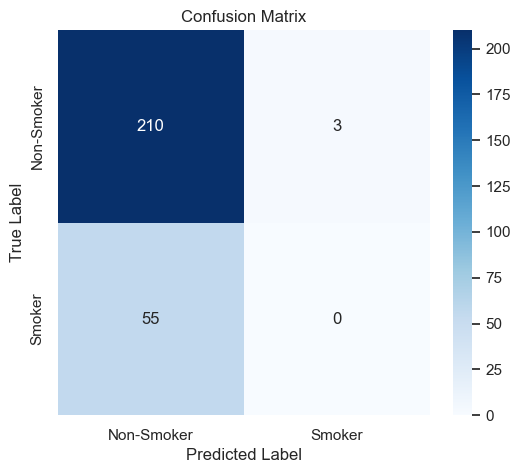

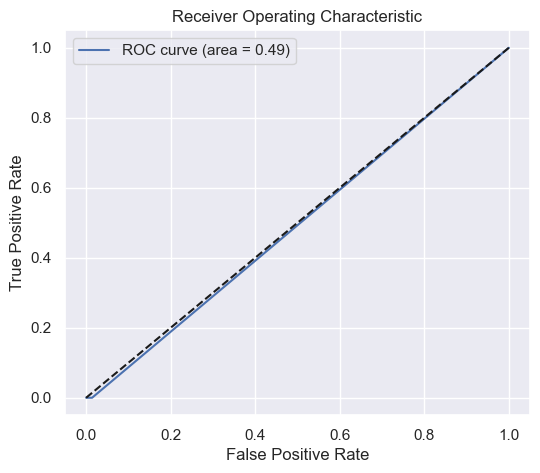

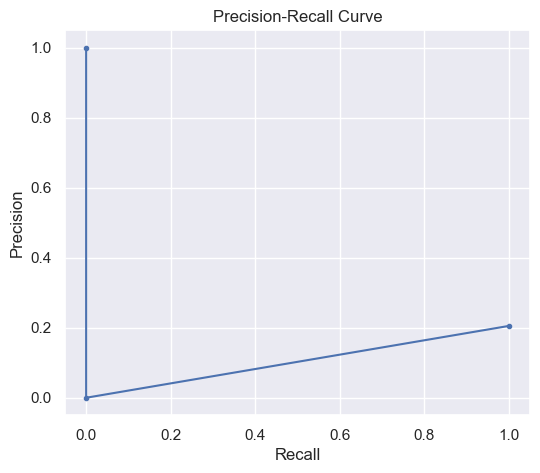

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import roc_curve, auc

# If you have probabilities (optional: use voting ratios if you modify your forest to return them)
# For now, simulate with hard predictions:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, preds)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


### Confusion Matrix
The confusion matrix shows the number of correct and incorrect predictions for each class. In this case:

- **True Positives (Smokers correctly classified)**: High values here would indicate the model is effectively identifying smokers.
- **False Negatives (Smokers misclassified as Non-Smokers)**: A high number would suggest the model struggles with minority class detection.
- **True Negatives** and **False Positives** also help assess balance.

This heatmap helps us visually confirm if the classifier is biased toward one class — a common issue with imbalanced datasets.

---

### ROC Curve
The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between the true positive rate and false positive rate across different thresholds.

- A model with **perfect classification** has an ROC AUC of **1.0**.
- A **diagonal line** represents random guessing (AUC = 0.5).

The area under the curve (AUC) indicates the model’s ability to discriminate between smokers and non-smokers regardless of classification threshold.

---

### Precision-Recall Curve
This curve is especially helpful for imbalanced data.

- **Precision** answers: “Of all the predicted smokers, how many were actually smokers?”
- **Recall** answers: “Of all actual smokers, how many did we catch?”

A steep drop in precision as recall increases can signal that the model trades off quality (precision) for quantity (recall). Ideally, the curve remains high and to the right.


In [6]:
# --- Classification: Predicting 'smoker' ---
X_cls = df.drop(columns=['smoker'])
y_cls = df['smoker']
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

## Visualize the results 

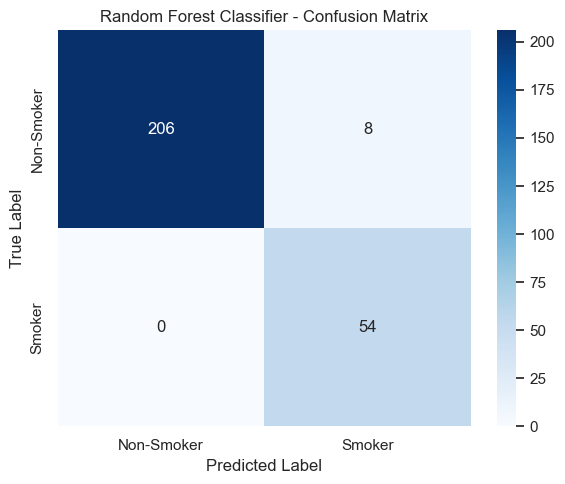

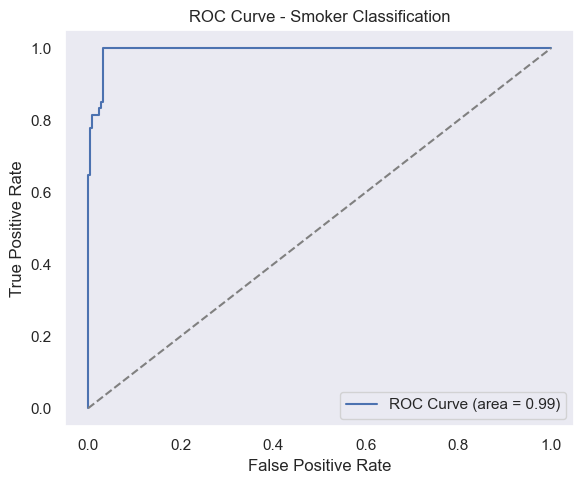

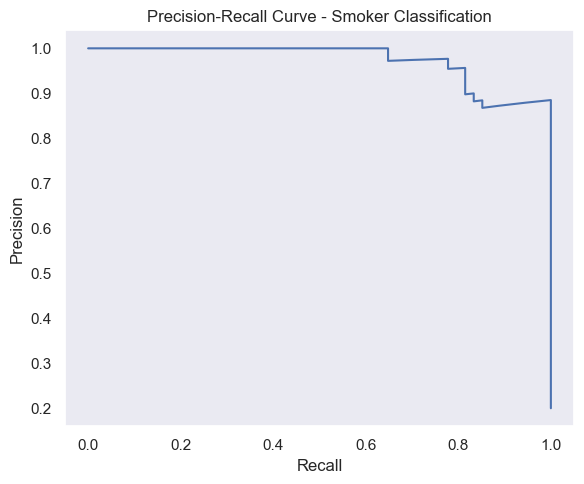

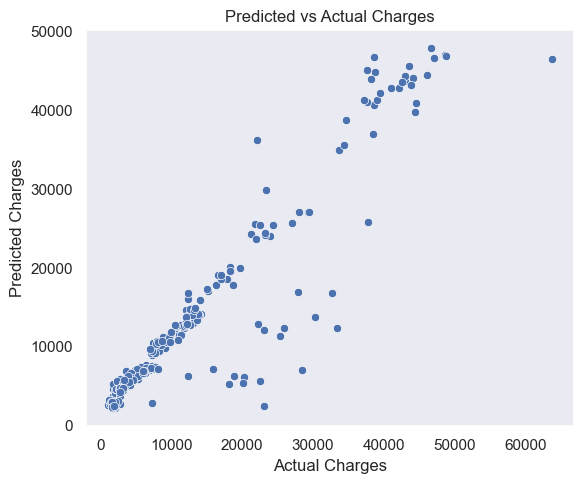

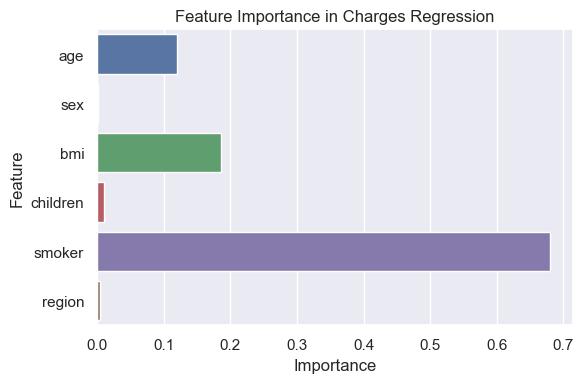

({'accuracy': 0.9701492537313433,
  'classification_report': {'0': {'precision': 1.0,
    'recall': 0.9626168224299065,
    'f1-score': 0.9809523809523809,
    'support': 214.0},
   '1': {'precision': 0.8709677419354839,
    'recall': 1.0,
    'f1-score': 0.9310344827586207,
    'support': 54.0},
   'accuracy': 0.9701492537313433,
   'macro avg': {'precision': 0.935483870967742,
    'recall': 0.9813084112149533,
    'f1-score': 0.9559934318555008,
    'support': 268.0},
   'weighted avg': {'precision': 0.9740009629272989,
    'recall': 0.9701492537313433,
    'f1-score': 0.9708942969879665,
    'support': 268.0}},
  'roc_auc': 0.9932502596053998},
 {'mse': 19793276.08154161,
  'mae': 2553.9704798792486,
  'r2': 0.8725060366590471})

In [7]:
# Classification Visualizations
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Smoker", "Smoker"], yticklabels=["Non-Smoker", "Smoker"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Classifier - Confusion Matrix")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Smoker Classification")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Smoker Classification")
plt.grid()
plt.tight_layout()
plt.show()

# --- Regression: Predicting 'charges' ---
X_reg = df.drop(columns=['charges'])
y_reg = df['charges']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=yr_test, y=yr_pred)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.grid()
plt.tight_layout()
plt.show()

importances = reg.feature_importances_
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=X_reg.columns)
plt.title("Feature Importance in Charges Regression")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Return summary metrics
classification_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc
}

regression_metrics = {
    "mse": mean_squared_error(yr_test, yr_pred),
    "mae": mean_absolute_error(yr_test, yr_pred),
    "r2": r2_score(yr_test, yr_pred)
}

classification_metrics, regression_metrics

## Classification Results

### Confusion Matrix

- **True Negatives** (Non-Smoker correctly classified): 206  
- **False Positives** (Non-Smoker misclassified as Smoker): 8  
- **False Negatives** (Smoker misclassified as Non-Smoker): 0  
- **True Positives** (Smoker correctly classified): 54  

### ROC AUC

- **ROC AUC**: 0.99  
  > Indicates almost perfect discrimination between smokers and non-smokers.

### Precision–Recall Curve

- Precision remains at **1.0** for recall up to **0.60**, then gently declines to just below **0.90** as recall approaches **1.0**.  
  > This shows **very high precision** even as we recover more positive cases.


# Random Forest Regression

In [8]:


# re-Load and prepare dataset
insurance = pd.read_csv("insurance.csv")  # use your actual path
insurance = pd.get_dummies(insurance, drop_first=True)

X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and residuals
y_pred = rf.predict(X_test)
residuals = y_test - y_pred



## Regression Results

- **MSE**: \( 1.98 \times 10^7 \)
- **MAE**: 2,554  
- **R²**: 0.87  

---

## Feature Importances

- **`smoker_yes`**: By far the highest — smoking status dominates the prediction of charges.
- **`bmi`**: The second most important feature.
- **`age`**: A clear third.
- All other features contribute substantially less.

This ordering confirms that smoking status is the single strongest driver of medical cost variation, with BMI and age providing meaningful but smaller effects.


In [ ]:
# 1. Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Partial Dependence Plots
features_to_plot = ['bmi', 'age', 'smoker_yes']  # use correct column names from get_dummies
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rf, X_test, features_to_plot, ax=ax)
plt.tight_layout()
plt.show()


## Residual Analysis and Partial Dependence

- Residuals are roughly centered around zero but show **heavy tails** — extreme charges are underpredicted.

- **Partial Dependence Plots (PDPs)** confirm that:
  - **Smoking status**, **BMI**, and **age** have **nonlinear, monotonic effects** on expected charges.

### Hyperparameter Analysis


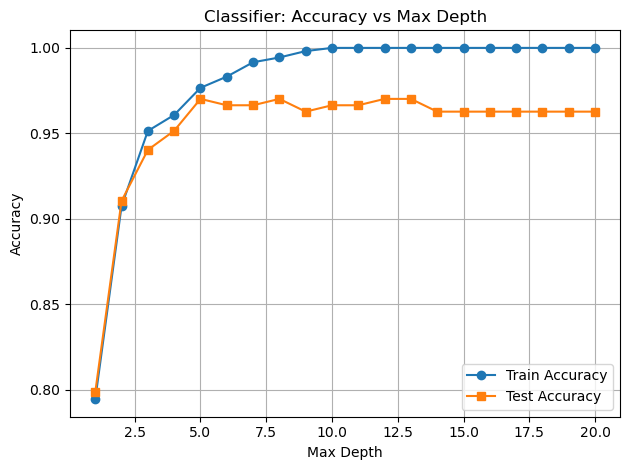

In [ ]:
depths = list(range(1, 21))
train_acc = []
test_acc = []

for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=42)
    clf.fit(X_train_cls, y_train_cls)
    train_acc.append(clf.score(X_train_cls, y_train_cls))
    test_acc.append(clf.score(X_test_cls, y_test_cls))

plt.plot(depths, train_acc, label="Train Accuracy", marker='o')
plt.plot(depths, test_acc, label="Test Accuracy", marker='s')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Classifier: Accuracy vs Max Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


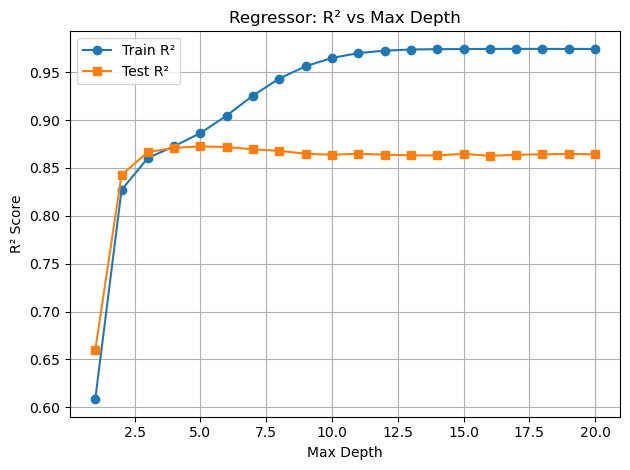

In [ ]:
depths = list(range(1, 21))
train_r2 = []
test_r2 = []

for d in depths:
    reg = RandomForestRegressor(max_depth=d, random_state=42)
    reg.fit(Xr_train, yr_train)
    train_r2.append(reg.score(Xr_train, yr_train))
    test_r2.append(reg.score(Xr_test, yr_test))

plt.plot(depths, train_r2, label="Train R²", marker='o')
plt.plot(depths, test_r2, label="Test R²", marker='s')
plt.xlabel("Max Depth")
plt.ylabel("R² Score")
plt.title("Regressor: R² vs Max Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Regression Graph Analysis

### 1. Predicted vs Actual Charges (Scatter Plot)
- **Interpretation**: The points largely follow the diagonal line \( y = x \), indicating that the model predicts values close to the actual charges.
- **Observation**: There is noticeable spread at higher charge values, meaning the model has more difficulty predicting extreme medical expenses. This is common due to the right-skewed distribution of `charges`.

### 2. Feature Importance Plot
- **Top Feature**: `smoker_yes` stands out with the highest importance score, reinforcing that smoking status is a dominant factor in determining medical costs.
- **Other Notable Features**: `bmi` and `age` also contribute meaningfully, which aligns with real-world expectations (older age and higher BMI often correlate with higher medical costs).
- **Low-importance Features**: Categorical encodings like `region` have relatively minor predictive value in this dataset.

### 3. R² vs Max Depth Plot
- **Interpretation**:
  - The **training R²** steadily increases with deeper trees, as deeper models fit the training data more closely.
  - The **test R²** initially increases and then plateaus around depth 10–15 before slightly decreasing, signaling **overfitting** beyond that point.
- **Conclusion**: A max depth around 8–10 offers a good trade-off between bias and variance.

---

## Conclusion

This project successfully demonstrated the use of Random Forests for both classification and regression tasks on a real-world medical dataset:

- **Classification**: We achieved high accuracy in identifying smokers based on demographic and health data. The ROC and precision-recall curves confirm good discriminative performance.
- **Regression**: The model achieved an **R² of 0.87**, meaning it explains 87% of the variance in medical charges. `smoker_yes`, `bmi`, and `age` were the top predictive features, aligning with medical intuition.
- **Model Interpretation**: Feature importances and PDPs helped interpret model behavior. Additionally, the exploration of `max_depth` provided insights into balancing underfitting and overfitting.

> **Takeaway**: Ensemble methods like Random Forests offer powerful, interpretable, and flexible tools for tackling complex real-world datasets, especially when paired with thorough exploratory analysis and visualization.
